In [27]:
from langgraph.graph import StateGraph, START, END, add_messages
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_community.tools import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv

load_dotenv()

memory=MemorySaver()

search_tools = TavilySearchResults(max_results=2)
tools = [search_tools]

llm = ChatGroq(model_name="llama-3.3-70b-versatile")
llm_with_tool = llm.bind_tools(tools)

class BasicState(TypedDict):
    messages: Annotated[List, add_messages]

def model(state: BasicState):
    return {
        "messages": [llm_with_tool.invoke(state["messages"])]
    }

def tools_router(state: BasicState): 
    last_message = state["messages"][-1]
    if(hasattr(last_message, "tool_calls") and 
    len(last_message.tool_calls) > 0):
        return "tools"
    else: 
        return END


graph = StateGraph(BasicState)
graph.add_node(model, "model")
graph.add_node("tools", ToolNode(tools=tools))

graph.set_entry_point("model")
graph.add_conditional_edges("model", tools_router)

graph.add_edge("tools", "model")

app = graph.compile(checkpointer=memory, interrupt_before=["tools"])



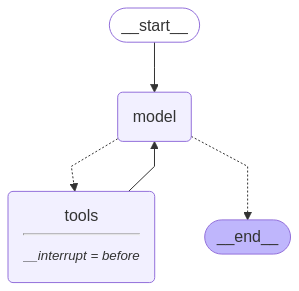

In [28]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [29]:
config = {"configurable": {
    "thread_id": 1
}}

events = app.stream({
    "messages": [HumanMessage(content="What is the current weather in Darmstadt, Germany?")]
}, config=config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the current weather in Darmstadt, Germany?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_bz23)
 Call ID: call_bz23
  Args:
    query: current weather Darmstadt Germany


In [30]:
snapshot = app.get_state(config=config)
snapshot.next

('tools',)

In [31]:
events = app.stream(None, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_bz23)
 Call ID: call_bz23
  Args:
    query: current weather Darmstadt Germany
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Weather in Darmstadt, Germany", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Darmstadt', 'region': 'Hessen', 'country': 'Germany', 'lat': 49.8706, 'lon': 8.6494, 'tz_id': 'Europe/Berlin', 'localtime_epoch': 1745532634, 'localtime': '2025-04-25 00:10'}, 'current': {'last_updated_epoch': 1745532000, 'last_updated': '2025-04-25 00:00', 'temp_c': 11.2, 'temp_f': 52.2, 'is_day': 0, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/night/116.png', 'code': 1003}, 'wind_mph': 2.2, 'wind_kph': 3.6, 'wind_degree': 228, 'wind_dir': 'SW', 'pressure_mb': 1016.0, 'pressure_in': 30.0, 'precip_mm': 0.02, 'precip_i